## CFFI, Ctypes, Cython: The good, the bad and the ugly

## Pycon Israel 2017

## Matti Picus

![The movie poster](https://images-na.ssl-images-amazon.com/images/M/MV5BMTQxNDcyMjE4NF5BMl5BanBnXkFtZTgwNTU4ODE5MDE@._V1_.jpg)

### Why did you bother to show up? There is a lecture about Grumpy and PyPy next door

Here is what we will do

<p></p>
<details>
<summary>The ``mandel`` image (5 minutes)</summary>  
  
  - Pure python  
  - Pure C  
  - Timing it
</details>  
<p></p>
<details>
<summary>How to mix C and Python (10 minutes)</summary>  
  - Ctypes  
  - Cython  
  - CFFI
</details>  
<p></p>
<details>
<summary>Comparison - which is the good, the bad, and the ugly (10 minutes)</summary>  
  - Boilerplate  
  - Maintenance  
  - Speed
</details>  
Questions

In [5]:
from __future__ import print_function, division
%matplotlib notebook
from timeit import default_timer as timer
import numpy as np
from PIL import Image

In [6]:
class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = np.empty(width*height, dtype=int)

def create_fractal(image, iters, func):
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, image.data, yy+x)

In [7]:
def mandel(x, y, max_iters, data, indx):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            data[indx] = i
            return i
    data[indx] = max_iters
    return max_iters

In [8]:
# Pure python
width = 1500
height = 1000
image = Img(width, height)
s = timer()
create_fractal(image, 20, mandel)
e = timer()
print('pure python required {:.2f} secs'.format(e - s))
im = Image.fromarray(image.data.reshape(height, width).astype('uint8'))
im.save('python_numpy.png')

pure python required 6.90 secs


<IPython.core.display.Javascript object>


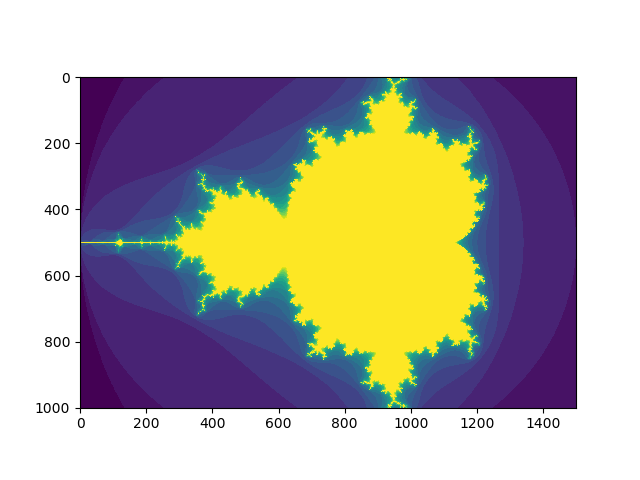

In [9]:
from PIL import Image
from matplotlib.pylab import imshow, show, figure, subplots
figure()
img = Image.open('python_numpy.png')
imshow(img); show()

In [10]:
%%bash 
cat mandel.c

#include <complex.h>

int mandel(float x, float y, int max_iters, unsigned int * val)
{
    int i = 0;
    _Complex float c = CMPLX(x, y);
    _Complex float z = CMPLX(0, 0);
    for (i = 0; i < max_iters; i++)
    {
        z = z * z + c;
        if ((crealf(z) * crealf(z) + cimagf(z) * cimagf(z)) >= 4)
        {
            *val = i;
            return 0;
        }
    }
    *val = max_iters;
    return 1;
}


In [11]:
%%bash 
cat create_fractal.c

int mandel(float x, float y, int max_iters, unsigned int * val);

typedef struct _Img{
    int width;
    int height;
    int * data;
} Img;


void create_fractal(Img img,  int iters) {
    float pixel_size_x = 3.0 / img.width;
    float pixel_size_y = 2.0 / img.height;
    for (int y=0; y < img.height; y++) {
        float imag = y * pixel_size_y - 1;
        int yy = y * img.width;
        for (int x=0; x < img.width; x++) {
            float real = x * pixel_size_x - 2;
            unsigned int color;
            int ret = mandel(real, imag, iters, &color);
            img.data[yy + x] = color;
        }
    }
}


In [12]:
%%bash
cat main.c

#include <stdio.h>
#include <pgm.h>
#include <time.h>

// call this function to start a nanosecond-resolution timer
struct timespec timer_start(){
    struct timespec start_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &start_time);
    return start_time;
}

// call this function to end a timer, returning nanoseconds elapsed as a long
long timer_end(struct timespec start_time){
    struct timespec end_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &end_time);
    long diffInNanos = end_time.tv_nsec - start_time.tv_nsec;
    return diffInNanos;
}

#include "create_fractal.c"

int main(int argc, const char *argv[], const char * env[])
{
    int width = 1500;
    int height = 1000;
    int iters = 20;
    FILE * fid = NULL;
    Img img;
    struct timespec vartime;
    long time_elapsed_nanos;
    img.width = width;
    img.height = height;
    img.data = (unsigned int*)malloc(width * height * sizeof(unsigned int));
    if (NULL == img.data)
        return -1;

    vartime = timer_

In [21]:
%%bash
gcc --shared -fPIC -O3 mandel.c create_fractal.c -o libcreate_fractal.so
gcc -O3 main.c -lnetpbm -L. -lcreate_fractal -o main
time (LD_LIBRARY_PATH=. ./main)

create_fractal required 184 millisecs



real	0m0.199s
user	0m0.196s
sys	0m0.000s


<IPython.core.display.Javascript object>


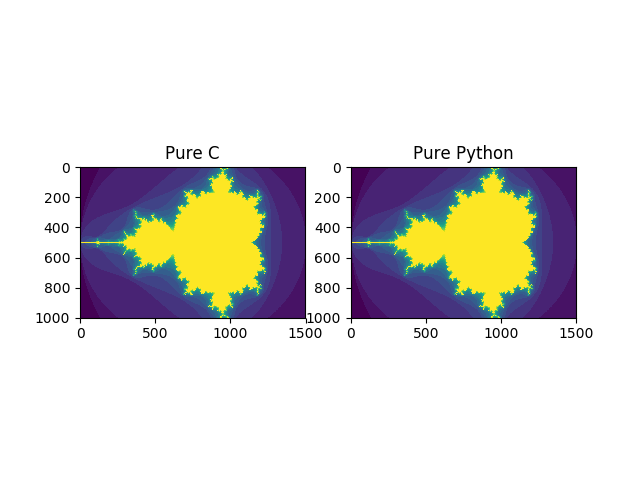

In [16]:
from matplotlib.pylab import imshow, show, figure, subplots
fig, ax = subplots(1,2)
img = Image.open('c.pgm')
ax[0].imshow(img); ax[0].set_title('Pure C')
img = Image.open('python_numpy.png')
ax[1].imshow(img); ax[1].set_title('Pure Python')
fig.show()

In [ ]:
#ctypes
import ctypes
import numpy as np
from timeit import default_timer as timer
from PIL import Image, ImageFilter

class CImg(ctypes.Structure):
    _fields_ = [('width', ctypes.c_int),
                ('height', ctypes.c_int),
                ('data', ctypes.POINTER(ctypes.c_int)),
               ]

cdll = ctypes.cdll.LoadLibrary('./libcreate_fractal.so')
create_fractal1 = cdll.create_fractal
create_fractal1.argtypes = [CImg, ctypes.c_int]

mandel1 = cdll.mandel
mandel1.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_int, ctypes.POINTER(ctypes.c_int)]

width = 1500
height = 1000

In [17]:
data1 = np.zeros(width*height, dtype=np.int32)
img = CImg()
img.width = width
img.height = height
img.data = data1.ctypes.data_as(ctypes.POINTER(ctypes.c_int))
s = timer()
create_fractal1(img, 20)
e = timer()
print('ctypes calling create_fractal required {:.2f} millisecs'.format(1000*(e - s)))
im = Image.fromarray(data1.reshape(height, width).astype('uint8'))
im.save('ctypes_fractal.png')


def create_fractal_wrapper1(img, iters, func):
    pixel_size_x = 3.0 / img.width
    pixel_size_y = 2.0 / img.height
    color = ctypes.c_int()
    for y in range(img.height):
        imag = y * pixel_size_y - 1
        yy = y * img.width
        for x in range(img.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, color)
            img.data[yy+x] = color

data2 = np.zeros(width*height, dtype=np.int32)
img.data = data2.ctypes.data_as(ctypes.POINTER(ctypes.c_int))            
s = timer()
create_fractal_wrapper1(img, 20, mandel1)
e = timer()
print('ctypes calling mandel required {:.2f} millisecs'.format(1000*(e - s)))
im = Image.fromarray(data2.reshape(height, width).astype('uint8'))
im.save('ctypes_mandel.png')

ctypes calling create_fractal required 174.08 millisecs
ctypes calling mandel required 2363.01 millisecs


<IPython.core.display.Javascript object>


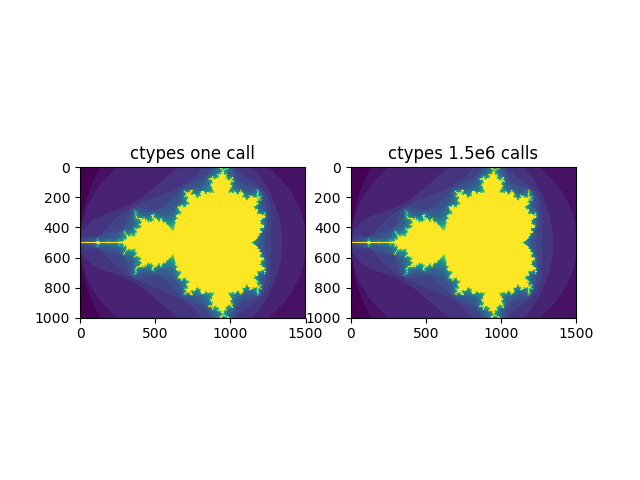

In [20]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('ctypes_fractal.png')
ctypes2 = Image.open('ctypes_mandel.png')
ax[0].imshow(data1.reshape(height, width)); ax[0].set_title('ctypes one call')
ax[1].imshow(data2.reshape(height, width)); ax[1].set_title('ctypes 1.5e6 calls')
fig.show()

In [22]:
#cffi
import cffi
ffi = cffi.FFI()
ffi.cdef('''
int mandel(float x, float y, int max_iters, unsigned int * val);

typedef struct _Img{
    int width;
    int height;
    int * data;
} Img;

void create_fractal(Img img,  int iters);
''')

dll = ffi.dlopen('./libcreate_fractal.so')

In [23]:
img = ffi.new('Img[1]')
img[0].width = width
img[0].height = height
#img[0].data = ffi.new('int[%d]' % width*height) # NO NO NO NO
data1 = ffi.new('int[%d]' % (width*height,))
img[0].data = data1

s = timer()
dll.create_fractal(img[0], 20)
e = timer()
print('cffi calling create_fractal required {:.2f} millisecs'.format(1000*(e - s)))

im = Image.fromarray(np.array(ffi.buffer(data1)).view('int32').reshape(height, width).astype('uint8'))
im.save('cffi_fractal.png')


def create_fractal_wrapper2(img, iters, func):
    pixel_size_x = 3.0 / img.width
    pixel_size_y = 2.0 / img.height
    color = ffi.new('unsigned int[1]')
    for y in range(img.height):
        imag = y * pixel_size_y - 1
        yy = y * img.width
        for x in range(img.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, color)
            img.data[yy+x] = color[0]

data2 = ffi.new('int[%d]' % (width*height,))
img[0].data = data2
s = timer()
create_fractal_wrapper2(img[0], 20, dll.mandel)
e = timer()
print('cffi calling mandel required {:.2f} millisecs'.format(1000*(e - s)))
im = Image.fromarray(np.array(ffi.buffer(data1)).view('int32').reshape(height, width).astype('uint8'))
im.save('cffi_mandel.png')

cffi calling create_fractal required 231.66 millisecs
cffi calling mandel required 924.83 millisecs


<IPython.core.display.Javascript object>


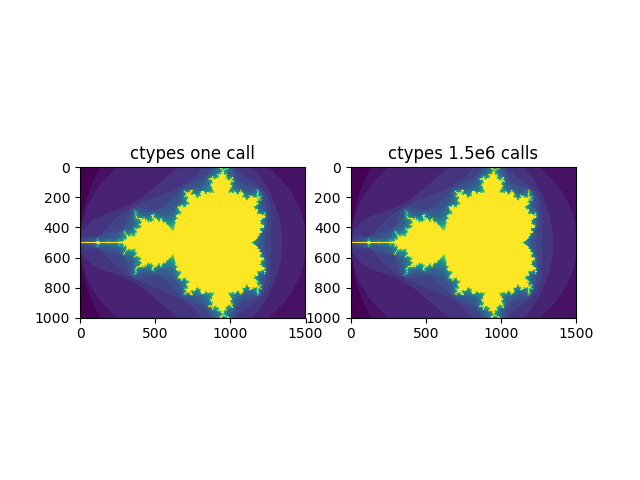

In [24]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cffi_fractal.png')
ctypes2 = Image.open('cffi_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('ctypes one call')
ax[1].imshow(ctypes2); ax[1].set_title('ctypes 1.5e6 calls')
fig.show()

In [ ]:
%load_ext Cython

In [40]:
import os
os.environ['LD_LIBRARY_PATH'] = '.:' + os.environ.get('LD_LIBRARY_PATH', '')

In [66]:
%%cython -a -L. -l create_fractal --link-args=-Wl,-rpath=.

cdef struct cImg:
        int width;
        int height;
        unsigned int * data;

cdef extern from *:
        
    int create_fractal(cImg img, int iters)
    int mandel(float real, float imag, int max_iters, unsigned int * val)
    
def cython_create_fractal(pyimg, iters):
    cdef cImg cimg
    cdef int citers
    cdef unsigned int[::1] tmp = pyimg.data
    
    citers = iters
    cimg.width = pyimg.width
    cimg.height = pyimg.height
    cimg.data = &tmp[0]
    return create_fractal(cimg, citers)

cpdef int cython_mandel(float real, float imag, int max_iters, unsigned int[:] val, int index):
    return mandel(real, imag, max_iters, &val[index])

In [75]:
# use it
class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = np.empty(width*height, dtype='uint32')

def create_fractal(image, iters, func):
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, image.data, yy+x)
            
width = 1500
height = 1000
image = Img(width, height)

s = timer()
create_fractal(image, 20, cython_mandel)
e = timer()
print('cython mandel call required {:.2f} secs'.format(e - s))
im = Image.fromarray(image.data.reshape(height, width).astype('uint8'))
im.save('cython_mandel.png')
s = timer()
cython_create_fractal(image, 20)
e = timer()
print('cython fractal call required {:.2f} millisecs'.format(1000*(e - s)))
im = Image.fromarray(image.data.reshape(height, width).astype('uint8'))
im.save('cython_fractal.png')

cython mandel call required 1.32 secs
cython fractal call required 174.06 millisecs


<IPython.core.display.Javascript object>


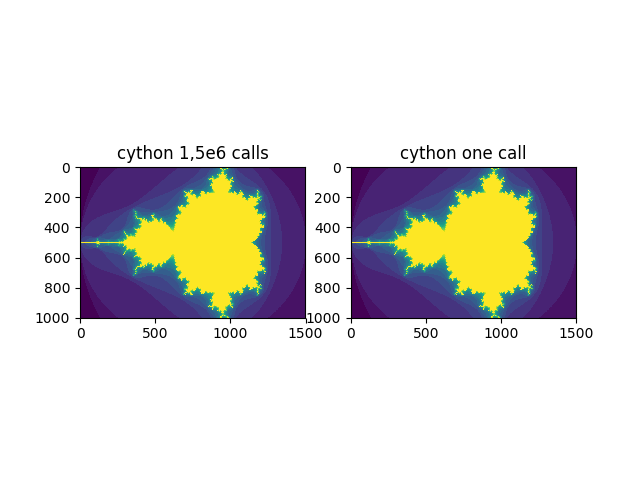

In [76]:
fig, ax = subplots(1,2)
cython1 = Image.open('cython_mandel.png')
cython2 = Image.open('cython_fractal.png')
ax[0].imshow(ctypes1); ax[0].set_title('cython 1,5e6 calls')
ax[1].imshow(ctypes2); ax[1].set_title('cython one call')
fig.show()